In [2]:
import torch
import torch.nn as nn
from utils import data_loader
from utils.viewer import show_batch
import time
from vae_models import VAE_CONV_NeuralModel

In [2]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [3]:
train_set, test_set = data_loader.get_data()

In [4]:
class VAE_CONV_NeuralModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)

        )

        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 16, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True)
        )

        self.fc_mu = nn.Linear(50, 50)
        self.fc_log_var = nn.Linear(50, 50)

        # Sampling vector
        self.latent = nn.Sequential(

            nn.Linear(50, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),

            nn.Linear(50, 7 * 7 * 16),
            nn.BatchNorm1d(7 * 7 * 16),
            nn.ReLU(inplace=True)

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()

        )

    def reparameterize(self, mean, log_var):
        if self.training:
            std = log_var.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mean)
        else:
            return mean

    def forward(self, x):
        encoded = self.encoder(x)

        encoded = encoded.view(-1, 7 * 7 * 16)

        fc = self.fc(encoded)

        mu = self.fc_mu(fc)
        log_var = self.fc_log_var(fc)

        z = self.reparameterize(mu, log_var)
        latent = self.latent(z)
        latent = latent.view(-1, 16, 7, 7)

        decoded = self.decoder(latent)
        output = decoded.view(-1, 1, 28, 28)

        return output, mu, log_var

In [5]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# vae = VAE_FC_NeuralModel()


def VAELoss(x_hat, x, mu, logvar, a, b):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return a*BCE + b*KLD

In [6]:
def train_vae(model, train_data,a, b):
    lr = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    n_epochs = 10
    model.train()
    model.to(device)
    for epoch in range(n_epochs):

        for batch in train_data:
            batch_images, _ = batch
            batch_images = batch_images.to(device)
            
            batch_output, mean, log_var = model(batch_images)
            loss = VAELoss(batch_output, batch_images, mean, log_var, alpha, beta)

            optimizer.zero_grad()
            loss.backward()
            #print("the loss after processing this batch is: ", loss.item())
            optimizer.step()

        if epoch % 3 == 0:
            lr /= 2
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Beta =  1
torch.Size([64, 1, 28, 28])


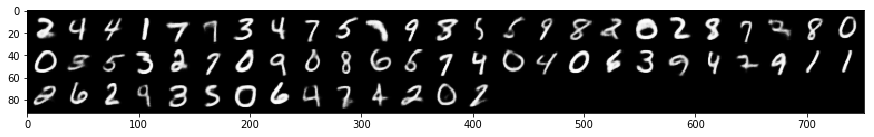

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Beta =  2
torch.Size([64, 1, 28, 28])


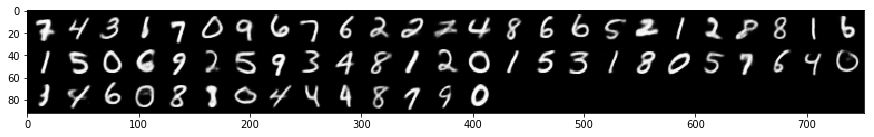

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Beta =  3
torch.Size([64, 1, 28, 28])


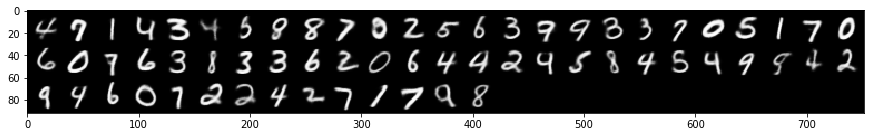

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Beta =  4
torch.Size([64, 1, 28, 28])


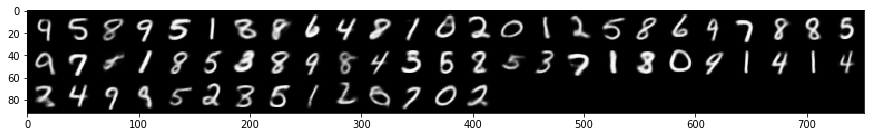

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Beta =  5
torch.Size([64, 1, 28, 28])


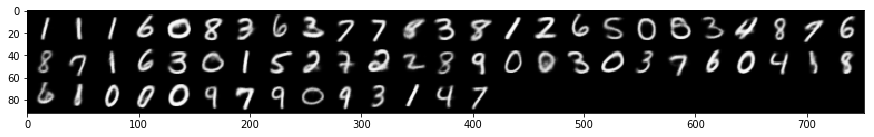

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Beta =  6
torch.Size([64, 1, 28, 28])


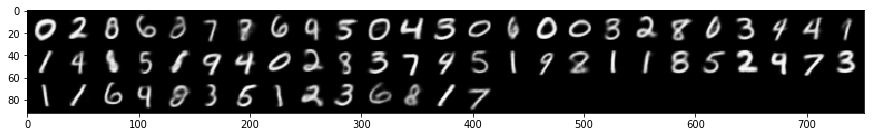

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Beta =  7
torch.Size([64, 1, 28, 28])


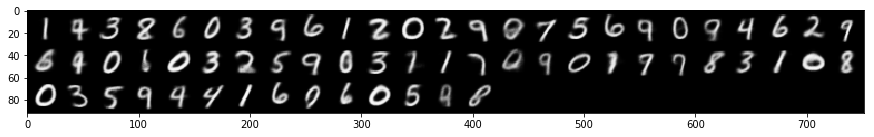

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Beta =  8
torch.Size([64, 1, 28, 28])


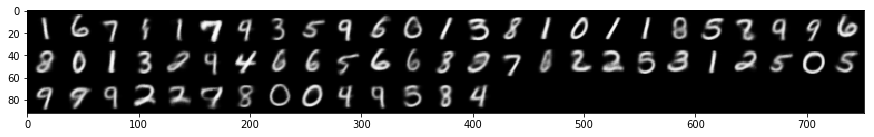

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Beta =  9
torch.Size([64, 1, 28, 28])


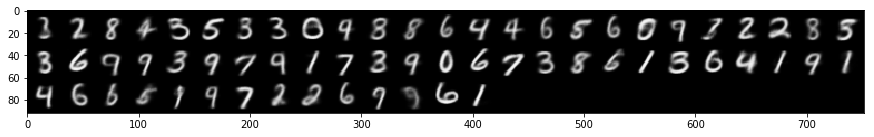

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Beta =  10
torch.Size([64, 1, 28, 28])


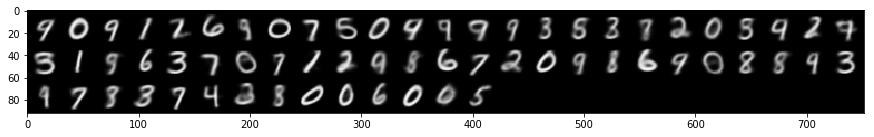

In [10]:
def main():
    pass


if __name__ == "__main__":
    vae = VAE_CONV_NeuralModel()
    
    alpha = 1
    
    
    for beta in range(1,11):
        print("=*="*15)
        print("Beta = ", beta)
        
#         vae = train_vae(vae, train_loader, alpha, beta)
    
#         torch.save(vae.state_dict(), "models/trained_CONV_vae_B="+str(beta))

        vae = VAE_CONV_NeuralModel().to(device)
        vae.load_state_dict(torch.load("models/trained_CONV_vae_B="+str(beta)))


        first_batch = next(iter(train_loader))
        first_images, _ = first_batch
        first_images = first_images.to(device)
        recs, _, _ = vae(first_images)

        recs = recs.reshape(batch_size, 1, 28, 28)
        recs = recs.cpu()
        print(recs.shape)
        # show_batch(first_images)
        show_batch(recs)

        main()
  